In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Link del dataset utilitzat: https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data/data

S'han descarregat els arxius CSV 'yellow_tripdata_2016-01.csv' i 'yellow_tripdata_2016-02.csv', referents als mesos de gener i febrer del 2016

In [2]:
def ls2(path): 
    return [obj.name for obj in os.scandir(path) if obj.is_file()]

data_path = "./DATA" # ruta de la carpeta on es troben els arxius csv.
files = ls2(data_path)

for index, file in enumerate(files):
    file_path = os.path.join(data_path, file)
    if index == 0:
        df = pd.read_csv(file_path)
    else:
        df = pd.concat([df, pd.read_csv(file_path)], ignore_index=True)

# Eliminar filas duplicadas basadas en todas las columnas
df = df.drop_duplicates()

In [3]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.00,0.00,0.3,8.80
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.00,0.00,0.3,19.30
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.00,0.00,0.3,34.30
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.00,0.00,0.3,17.30
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.00,0.00,0.3,8.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22288902,1,2016-02-13 22:38:51,2016-06-24 12:30:49,2,2.60,-73.990425,40.766392,1,N,-73.961891,40.779392,2,14.0,0.0,0.5,0.00,0.00,0.3,14.80
22288903,1,2016-02-13 22:39:42,2016-06-23 02:10:11,1,2.60,-74.007370,40.743530,1,N,-73.987778,40.763790,1,10.5,0.5,0.5,2.35,0.00,0.3,14.15
22288904,1,2016-02-13 22:39:49,2016-06-25 12:32:54,2,1.10,-73.921600,40.743774,1,N,-73.914467,40.753582,2,6.0,0.0,0.5,0.00,0.00,0.3,6.80
22288905,1,2016-02-13 22:42:34,2016-06-26 11:55:57,2,10.10,-73.872925,40.774002,1,N,-73.973198,40.755211,1,28.5,0.0,0.5,6.95,5.54,0.3,41.79


# 1. Netetja de les dades

In [4]:
# Convertim les columnes tpep_pickup_datetime i tpep_dropoff_datetime a tipus datetime
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Calculam la durada del trajecte en segons i afegim la columna duration_seconds
df['duration_seconds'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()

# 1.1. Informació de Fonts
Segons la font https://www.flickr.com/places/info/2459115.
Es dedueix que Nova York es troba limitada per les coordenades d'ubicació (lat, long) - (40.5774, -74.15) i (40.9176,-73.7004).
Per tant, no es tindran en compte les coordenades que no estigui dins d'aquest rang.

In [5]:
outliers = df[((df['pickup_longitude'] <= -74.15) | (df['pickup_latitude'] <= 40.5774)| (df['pickup_longitude'] >= -73.7004) | (df['pickup_latitude'] >= 40.9176))]
print("Nombre de outliers eliminats:", len(outliers))

Nombre de outliers eliminats: 354092


Per altra banda, també hem trobat que segons la normativa de la NYC Taxi & Limousine Commision, la durada màxima permesa del viatge en un interval de 24 hores és de 12 hores.
https://www.nyc.gov/site/tlc/index.page

Per això, no tindrem en compte els viatges on la durada sigui major a 12 h (43.200 seg.), i aprofitarem per eliminar els viatges on la durada sigui de 0 seg.

In [6]:
# Eliminam les columnes on el la durada sigui superior a 43200 seg i igual a 0
df = df[(df['duration_seconds'] < 43201) & (df['duration_seconds'] > 0)]

# Reseteam l'index
df = df.reset_index(drop=True)
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration_seconds
0,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,-73.913490,40.763142,2,19.0,0.5,0.5,0.00,0.0,0.3,20.30,1110.0
1,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,-73.966362,40.789871,2,26.0,0.5,0.5,0.00,0.0,0.3,27.30,1605.0
2,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,-73.992035,40.753944,2,9.0,0.5,0.5,0.00,0.0,0.3,10.30,714.0
3,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,-73.920769,40.865578,2,18.0,0.5,0.5,0.00,0.0,0.3,19.30,672.0
4,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,-73.995850,40.688400,2,11.5,0.5,0.5,0.00,0.0,0.3,12.80,666.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22234040,1,2016-02-13 22:40:05,2016-02-13 22:49:30,1,0.60,-73.983788,40.744068,1,N,-73.991463,40.749416,1,7.0,0.0,0.5,1.55,0.0,0.3,9.35,565.0
22234041,1,2016-02-13 22:43:23,2016-02-13 23:12:01,2,1.50,-73.987480,40.768906,1,Y,-73.966599,40.764339,2,17.0,0.0,0.5,0.00,0.0,0.3,17.80,1718.0
22234042,1,2016-02-13 23:13:38,2016-02-13 23:46:36,2,2.70,-73.966904,40.764091,1,N,-73.991402,40.750130,2,19.5,0.0,0.5,0.00,0.0,0.3,20.30,1978.0
22234043,1,2016-02-13 22:38:02,2016-02-13 22:38:10,1,0.00,-73.962357,40.777374,1,N,-73.962242,40.777428,3,2.5,1.0,0.5,0.00,0.0,0.3,4.30,8.0


# 1.2. Outliers
Per mirar els valors atípics, el que farem serà crear box plots de diferents columnes i mirar el percentil en el qual es troben els valors allunyats.

C:\Users\Alumne EIBD\anaconda3\envs\BD\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


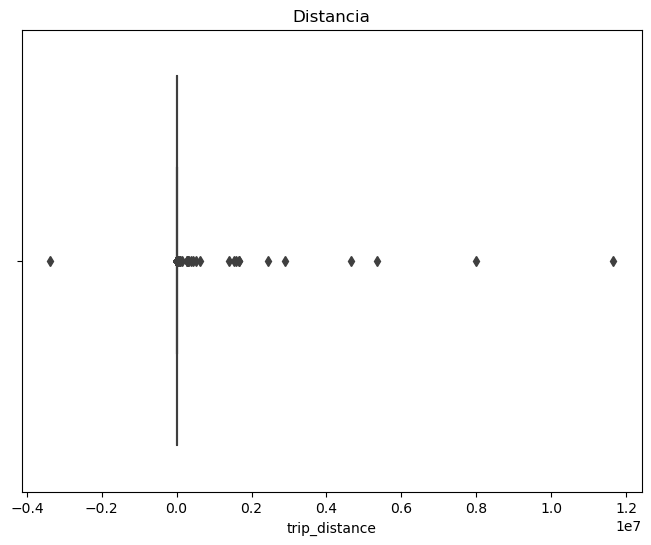

In [7]:
# Boxplot de la velocitat mitjana
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['trip_distance'])
plt.title('Distancia')
plt.show()

In [8]:
# Podem veure que hi ha valors fora del comú. El que farem serà mirar els percentils per trobar quin és el valor que s'allunya tant.

var = df["trip_distance"].values
var = np.sort(var,axis = None)

for i in np.arange(0.0, 1.0, 0.1):
    print("El percentil {} és {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("El percentil 100 és ",var[-1])

El percentil 99.0 és 18.53
El percentil 99.1 és 18.76
El percentil 99.2 és 19.0
El percentil 99.3 és 19.3
El percentil 99.4 és 19.6
El percentil 99.5 és 20.01
El percentil 99.6 és 20.5
El percentil 99.7 és 21.09
El percentil 99.8 és 21.89
El percentil 99.9 és 24.47
El percentil 100 és  11658534.3


In [9]:
# Eliminam les files on la ditancia recorreguda sigui de 0
df = df[(df['trip_distance'] < 24.5) & (df['trip_distance'] > 0)]

C:\Users\Alumne EIBD\anaconda3\envs\BD\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


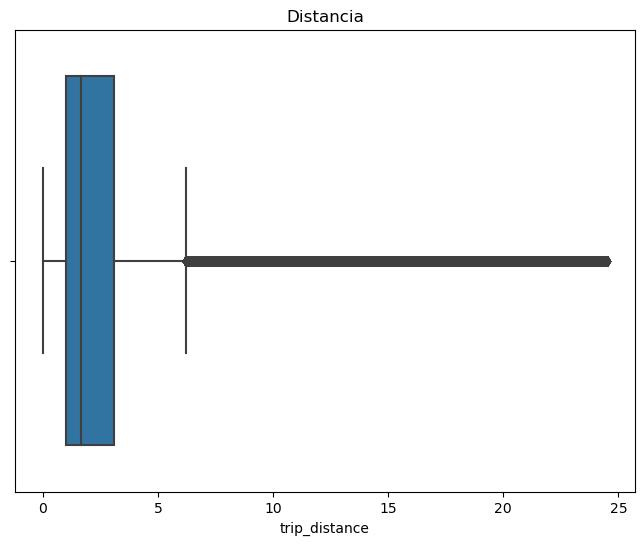

In [10]:
# Boxplot de la velocitat mitjana
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['trip_distance'])
plt.title('Distancia')
plt.show()

A continuació miram la velocitat mitjana a la qual anava el taxi. Per fer-ho, dividirem sa distància recorreguda per la duració del viatge, i ho passarem en hores.
Com que les dades són de Nova York, tindrem en compte que la distància es troba en milles.

In [11]:
# Calcular la velocitat mitjana en milles per hora
df['average_speed_mph'] = df['trip_distance'] / (df['duration_seconds'] / 3600)
df

C:\Users\Alumne EIBD\AppData\Local\Temp\ipykernel_3216\3371998001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['average_speed_mph'] = df['trip_distance'] / (df['duration_seconds'] / 3600)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration_seconds,average_speed_mph
0,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,-73.913490,...,2,19.0,0.5,0.5,0.00,0.00,0.3,20.30,1110.0,17.902703
1,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,-73.966362,...,2,26.0,0.5,0.5,0.00,0.00,0.3,27.30,1605.0,16.710280
2,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,-73.992035,...,2,9.0,0.5,0.5,0.00,0.00,0.3,10.30,714.0,6.050420
3,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,-73.920769,...,2,18.0,0.5,0.5,0.00,0.00,0.3,19.30,672.0,32.142857
4,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,-73.995850,...,2,11.5,0.5,0.5,0.00,0.00,0.3,12.80,666.0,17.351351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22234038,1,2016-02-13 23:02:36,2016-02-14 00:22:27,3,15.90,-73.785469,40.649506,2,Y,-73.981964,...,2,52.0,0.0,0.5,0.00,5.54,0.3,58.34,4791.0,11.947401
22234039,1,2016-02-13 22:44:03,2016-02-13 23:33:45,1,10.50,-73.872917,40.774086,1,N,-74.002251,...,2,38.5,0.0,0.5,0.00,0.00,0.3,39.30,2982.0,12.676056
22234040,1,2016-02-13 22:40:05,2016-02-13 22:49:30,1,0.60,-73.983788,40.744068,1,N,-73.991463,...,1,7.0,0.0,0.5,1.55,0.00,0.3,9.35,565.0,3.823009
22234041,1,2016-02-13 22:43:23,2016-02-13 23:12:01,2,1.50,-73.987480,40.768906,1,Y,-73.966599,...,2,17.0,0.0,0.5,0.00,0.00,0.3,17.80,1718.0,3.143190


C:\Users\Alumne EIBD\anaconda3\envs\BD\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


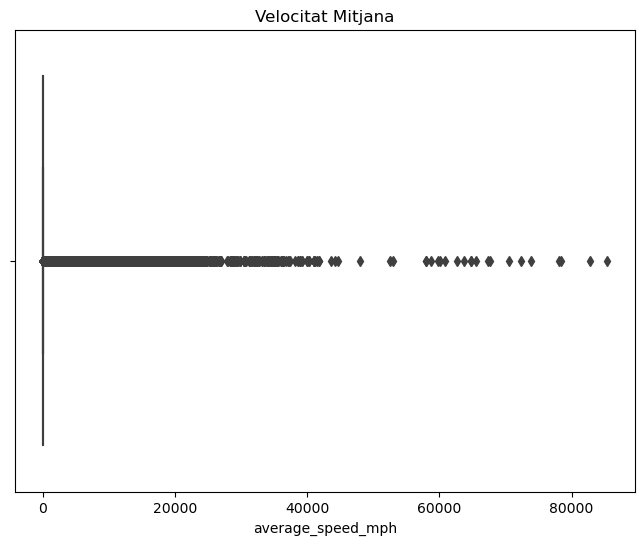

In [12]:
# Boxplot de la velocitat mitjana
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['average_speed_mph'])
plt.title('Velocitat Mitjana')
plt.show()

In [13]:
# Podem veure que hi ha valors fora del comú. El que farem serà mirar els percentils per trobar quin és el valor que s'allunya tant.

var = df["average_speed_mph"].values
var = np.sort(var,axis = None)

for i in np.arange(0.0, 1.0, 0.1):
    print("El percentil {} és {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("El percentil 100 és ",var[-1])

El percentil 99.0 és 35.35353535353536
El percentil 99.1 és 35.95913734392736
El percentil 99.2 és 36.60311958405546
El percentil 99.3 és 37.34306569343065
El percentil 99.4 és 38.16666666666667
El percentil 99.5 és 39.12138728323699
El percentil 99.6 és 40.295942720763726
El percentil 99.7 és 41.7877094972067
El percentil 99.8 és 43.956343792633014
El percentil 99.9 és 50.69836956521739
El percentil 100 és  85320.0


C:\Users\Alumne EIBD\anaconda3\envs\BD\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


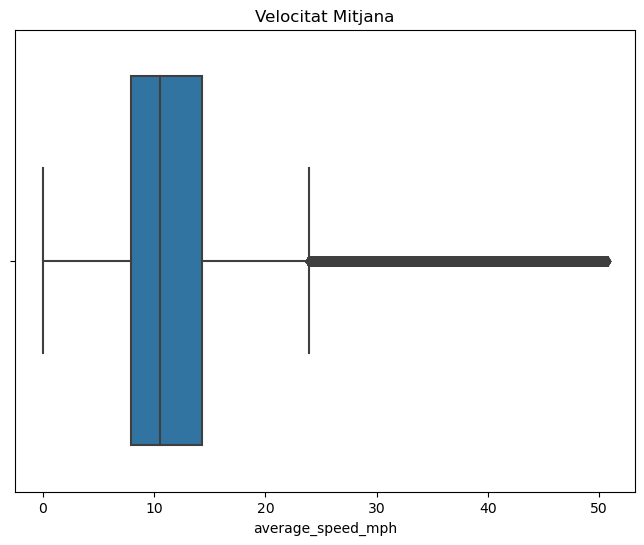

In [14]:
# El que farem és eliminar els outliners a partir del valor no atipic més gran i els que sigui igual a 0
df = df[(df['average_speed_mph'] > 0) & (df['average_speed_mph'] < 50.7)]

# Boxplot de la velocitat mitjana
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['average_speed_mph'])
plt.title('Velocitat Mitjana')
plt.show()

Ara mirarem els posibles valors atipics de la columna total amount

C:\Users\Alumne EIBD\anaconda3\envs\BD\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


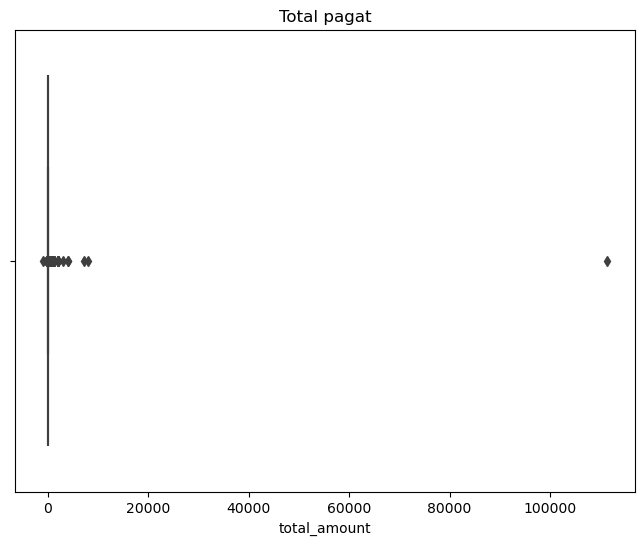

In [15]:
# Boxplot del total pagat
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['total_amount'])
plt.title('Total pagat')
plt.show()

In [16]:
var = df["total_amount"].values
var = np.sort(var,axis = None)

for i in np.arange(0.0, 1.0, 0.1):
    print("El percentil {} és {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("El percentil 100 és ",var[-1])

El percentil 99.0 és 69.99
El percentil 99.1 és 69.99
El percentil 99.2 és 70.01
El percentil 99.3 és 70.01
El percentil 99.4 és 70.01
El percentil 99.5 és 71.16
El percentil 99.6 és 72.92
El percentil 99.7 és 75.39
El percentil 99.8 és 79.3
El percentil 99.9 és 93.36
El percentil 100 és  111271.65


C:\Users\Alumne EIBD\anaconda3\envs\BD\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


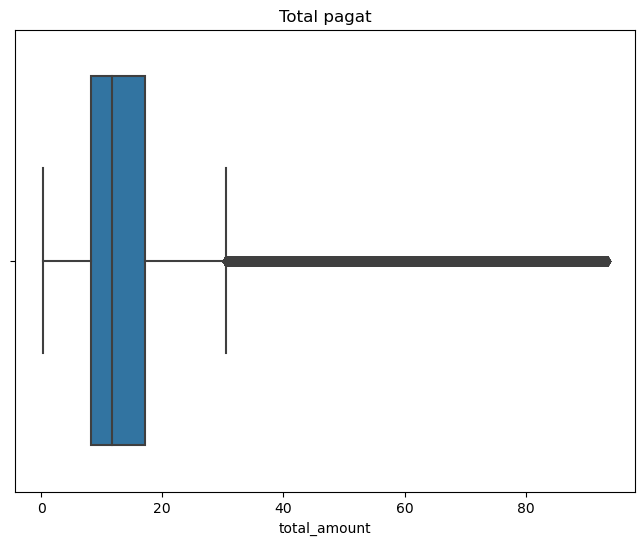

In [17]:
# El que farem és eliminar els outliners a partir del valor no atipic més gran i els que sigui igual a 0
df = df[(df['total_amount'] > 0) & (df['total_amount'] < 93.4)]

# Boxplot del total pagat
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['total_amount'])
plt.title('Total pagat')
plt.show()

In [18]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration_seconds,average_speed_mph
0,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,-73.913490,...,2,19.0,0.5,0.5,0.00,0.00,0.3,20.30,1110.0,17.902703
1,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,-73.966362,...,2,26.0,0.5,0.5,0.00,0.00,0.3,27.30,1605.0,16.710280
2,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,-73.992035,...,2,9.0,0.5,0.5,0.00,0.00,0.3,10.30,714.0,6.050420
3,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,-73.920769,...,2,18.0,0.5,0.5,0.00,0.00,0.3,19.30,672.0,32.142857
4,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,-73.995850,...,2,11.5,0.5,0.5,0.00,0.00,0.3,12.80,666.0,17.351351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22234038,1,2016-02-13 23:02:36,2016-02-14 00:22:27,3,15.90,-73.785469,40.649506,2,Y,-73.981964,...,2,52.0,0.0,0.5,0.00,5.54,0.3,58.34,4791.0,11.947401
22234039,1,2016-02-13 22:44:03,2016-02-13 23:33:45,1,10.50,-73.872917,40.774086,1,N,-74.002251,...,2,38.5,0.0,0.5,0.00,0.00,0.3,39.30,2982.0,12.676056
22234040,1,2016-02-13 22:40:05,2016-02-13 22:49:30,1,0.60,-73.983788,40.744068,1,N,-73.991463,...,1,7.0,0.0,0.5,1.55,0.00,0.3,9.35,565.0,3.823009
22234041,1,2016-02-13 22:43:23,2016-02-13 23:12:01,2,1.50,-73.987480,40.768906,1,Y,-73.966599,...,2,17.0,0.0,0.5,0.00,0.00,0.3,17.80,1718.0,3.143190


# 2. Preparació de dades

# 2.1. Convertim la recollida y la deixada en tipus datetime

In [19]:
df['tpep_pickup_datetime']=pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime']=pd.to_datetime(df['tpep_dropoff_datetime'])

# 2.2. Reducció de datasets que emplearem

In [40]:
# Dataset amb la primera semana de Gener

primera_semana_gener = df[(df['tpep_pickup_datetime'] >= pd.to_datetime('2016-01-02')) & (df['tpep_pickup_datetime'] < pd.to_datetime('2016-01-09'))]

# Reseteam l'index
primera_semana_gener = primera_semana_gener.reset_index(drop=True)
primera_semana_gener

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration_seconds,average_speed_mph
0,1,2016-01-02 00:46:26,2016-01-02 00:52:40,2,0.70,-73.997963,40.760559,1,N,-73.986671,...,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30,374.0,6.737968
1,1,2016-01-02 00:46:27,2016-01-02 00:58:35,1,4.40,-74.004059,40.738186,1,N,-73.973717,...,1,14.0,0.5,0.5,3.05,0.0,0.3,18.35,728.0,21.758242
2,1,2016-01-02 00:46:27,2016-01-02 01:00:16,1,3.10,-73.994568,40.752403,1,N,-73.990425,...,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55,829.0,13.462002
3,2,2016-01-02 00:46:27,2016-01-02 00:52:29,2,1.11,-73.985550,40.758018,1,N,-73.980865,...,2,6.0,0.5,0.5,0.00,0.0,0.3,7.30,362.0,11.038674
4,2,2016-01-02 00:46:27,2016-01-02 00:49:24,5,0.86,-73.986389,40.756676,1,N,-73.984840,...,2,5.0,0.5,0.5,0.00,0.0,0.3,6.30,177.0,17.491525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2355559,2,2016-01-08 23:59:59,2016-01-09 00:09:36,1,1.46,-73.958900,40.709446,1,N,-73.938881,...,2,8.5,0.5,0.5,0.00,0.0,0.3,9.80,577.0,9.109185
2355560,2,2016-01-08 23:59:59,2016-01-09 00:12:27,1,2.23,-73.985390,40.727440,1,N,-73.991211,...,1,10.5,0.5,0.5,2.36,0.0,0.3,14.16,748.0,10.732620
2355561,2,2016-01-08 23:59:59,2016-01-09 00:06:42,6,1.51,-73.950211,40.775661,1,N,-73.973030,...,1,7.0,0.5,0.5,1.66,0.0,0.3,9.96,403.0,13.488834
2355562,2,2016-01-08 23:59:59,2016-01-09 00:20:24,2,15.37,-73.781799,40.644775,1,N,-73.777039,...,1,42.0,0.5,0.5,6.00,0.0,0.3,49.30,1225.0,45.168980


In [42]:
# Dataset amb la primera semana de Gener

semana_sanvalentin = df[(df['tpep_pickup_datetime'] >= pd.to_datetime('2016-02-08')) & (df['tpep_pickup_datetime'] < pd.to_datetime('2016-02-15'))]

# Reseteam l'index
semana_sanvalentin = semana_sanvalentin.reset_index(drop=True)
semana_sanvalentin

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration_seconds,average_speed_mph
0,2,2016-02-10 17:30:41,2016-02-10 17:58:39,1,5.42,-73.984398,40.768581,1,N,-73.940186,...,2,20.0,1.0,0.5,0.00,0.00,0.3,21.80,1678.0,11.628129
1,2,2016-02-10 17:30:41,2016-02-10 17:35:47,1,0.60,-73.986572,40.740501,1,N,-73.991096,...,2,5.0,1.0,0.5,0.00,0.00,0.3,6.80,306.0,7.058824
2,2,2016-02-10 17:30:41,2016-02-10 17:42:23,1,2.06,-73.981369,40.784420,1,N,-73.964752,...,2,10.0,1.0,0.5,0.00,0.00,0.3,11.80,702.0,10.564103
3,2,2016-02-10 17:30:41,2016-02-10 17:36:57,3,0.92,-73.958763,40.780968,1,N,-73.971558,...,1,6.0,1.0,0.5,1.56,0.00,0.3,9.36,376.0,8.808511
4,1,2016-02-10 17:30:42,2016-02-10 17:56:49,1,6.60,-73.959480,40.814461,1,N,-74.000458,...,2,23.5,1.0,0.5,0.00,0.00,0.3,25.30,1567.0,15.162731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791688,1,2016-02-13 23:02:36,2016-02-14 00:22:27,3,15.90,-73.785469,40.649506,2,Y,-73.981964,...,2,52.0,0.0,0.5,0.00,5.54,0.3,58.34,4791.0,11.947401
2791689,1,2016-02-13 22:44:03,2016-02-13 23:33:45,1,10.50,-73.872917,40.774086,1,N,-74.002251,...,2,38.5,0.0,0.5,0.00,0.00,0.3,39.30,2982.0,12.676056
2791690,1,2016-02-13 22:40:05,2016-02-13 22:49:30,1,0.60,-73.983788,40.744068,1,N,-73.991463,...,1,7.0,0.0,0.5,1.55,0.00,0.3,9.35,565.0,3.823009
2791691,1,2016-02-13 22:43:23,2016-02-13 23:12:01,2,1.50,-73.987480,40.768906,1,Y,-73.966599,...,2,17.0,0.0,0.5,0.00,0.00,0.3,17.80,1718.0,3.143190


# 2.4. Creació de arxius csv nous per reduir tamany.

In [41]:
#convertim el dataframe primera_semana_gener en un nou arxiu csv

primera_semana_gener.to_csv('DATA_final/prim_semana_gener.csv', index=False)

In [43]:
# convertim el datframe de semana_sanvalentin en un nou arxiu csv

semana_sanvalentin.to_csv('DATA_final/semana_sanvalentin.csv', index=False)